## TP02 ATDN02 

Import nécessaire

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import shapiro, ttest_ind, zscore
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, KernelPCA
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score


(----------------------------------------------)
EXERCICE I
(----------------------------------------------)

(---------------------------------------)
moyenne : 2509.58
médiane : 2481.5
écart - type : 898.4368746263935
variance : 807188.8176884421
quantiles : {0.25: 1810.75, 0.5: 2481.5, 0.75: 3356.5}
(---------------------------------------)
(---------------------------------------)
moyenne : 129.745
médiane : 135.5
écart - type : 44.006166482008084
variance : 1936.5426884422116
quantiles : {0.25: 95.75, 0.5: 135.5, 0.75: 165.25}
(---------------------------------------)
(---------------------------------------)
moyenne : 28.389
médiane : 28.5
écart - type : 2.065723862324508
variance : 4.267215075376884
quantiles : {0.25: 26.6, 0.5: 28.5, 0.75: 30.3}
(---------------------------------------)


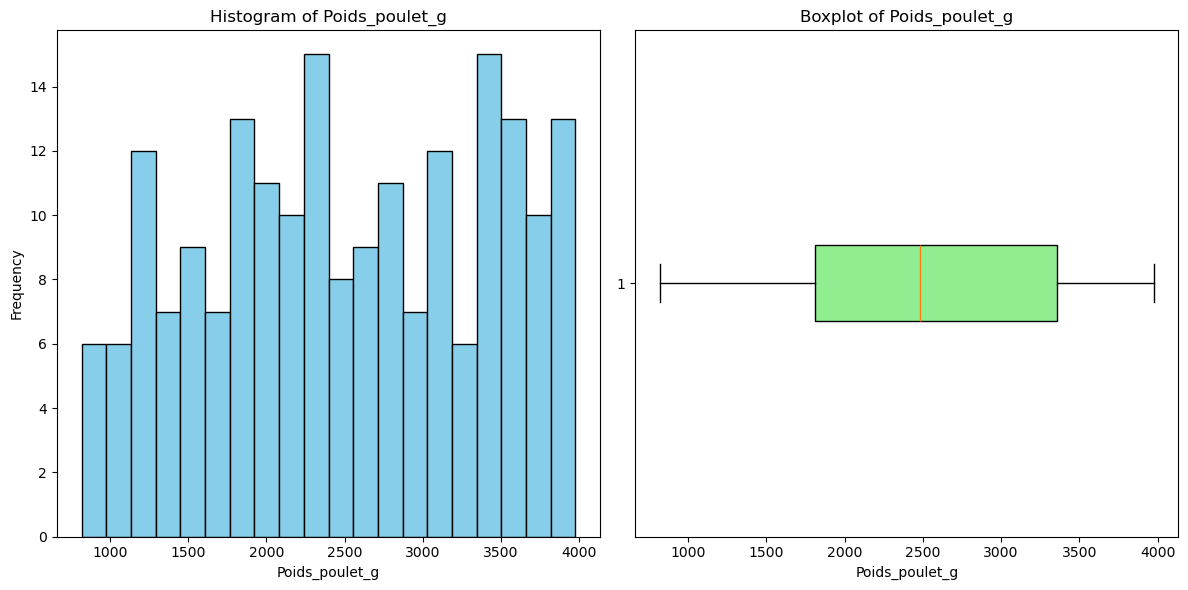

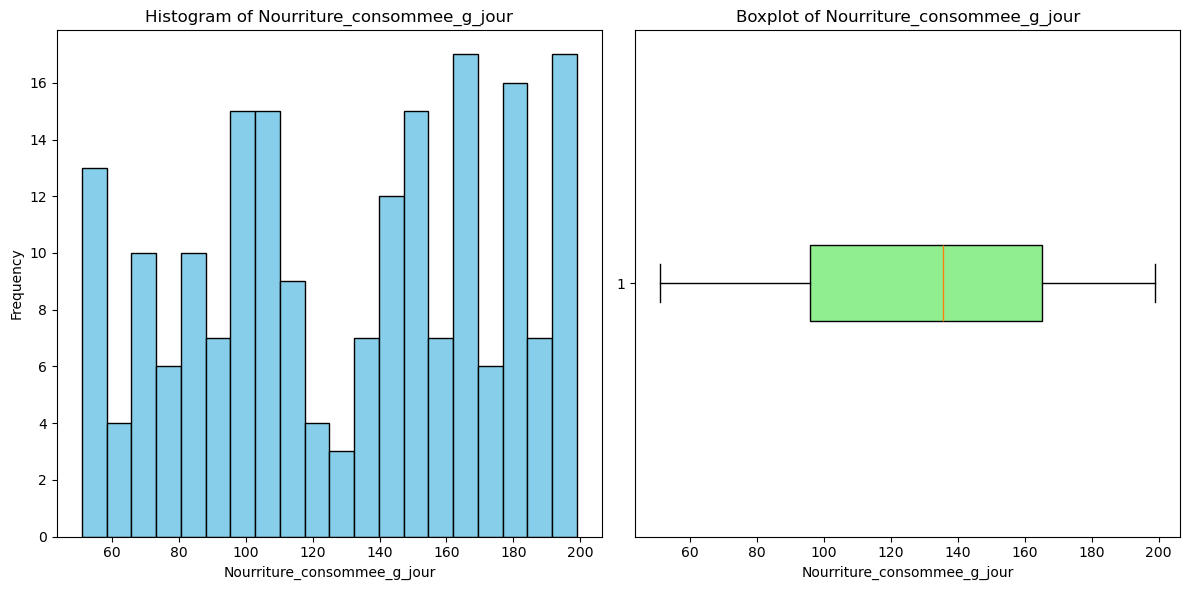

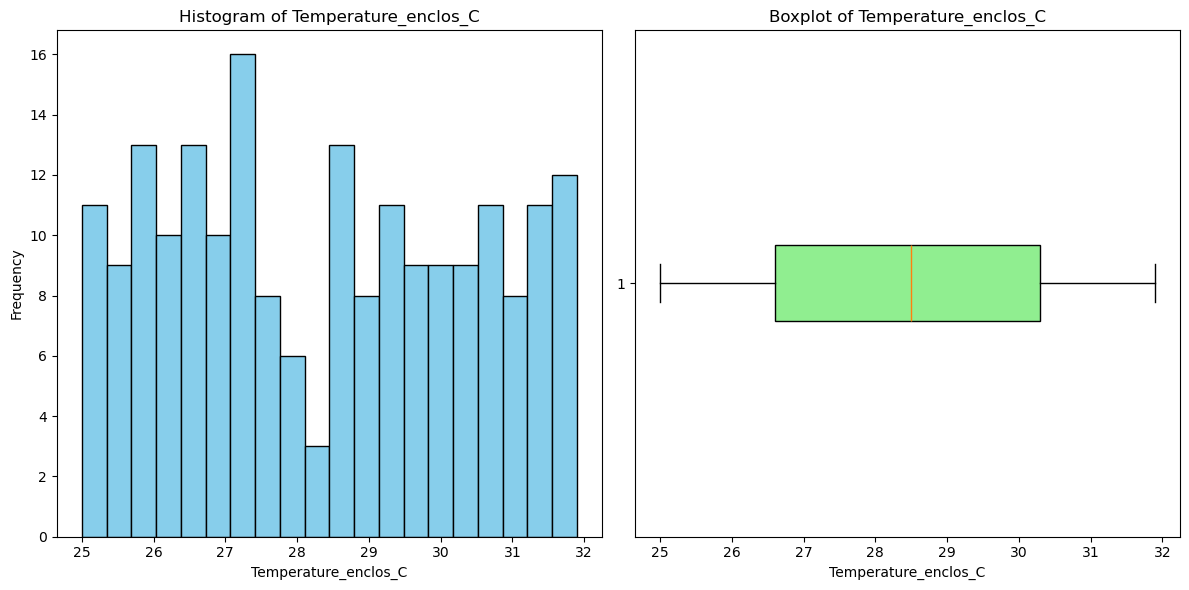

In [33]:

# Charger les données
data = pd.read_csv('donnees_elevage_poulet.csv')

# Variables à analyser
columns_to_analyze = ['Poids_poulet_g', 'Nourriture_consommee_g_jour', 'Temperature_enclos_C']

# Calcul des statistiques descriptives

for column in columns_to_analyze:
    print("(---------------------------------------)")
    print("moyenne :" ,data[column].mean())
    print("médiane :" ,data[column].median())
    print("écart - type :" ,data[column].std())
    print("variance :" ,data[column].var())
    print("quantiles :" ,data[column].quantile([0.25, 0.5, 0.75]).to_dict())
    print("(---------------------------------------)")


# Visualisation des histogrammes et boxplots
for column in columns_to_analyze:
    plt.figure(figsize=(12, 6))

    # Histogramme
    plt.subplot(1, 2, 1)
    plt.hist(data[column], bins=20, color='skyblue', edgecolor='black')
    plt.title(f'Histogram of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')

    # Boxplot
    plt.subplot(1, 2, 2)
    plt.boxplot(data[column], vert=False, patch_artist=True, boxprops=dict(facecolor='lightgreen'))
    plt.title(f'Boxplot of {column}')
    plt.xlabel(column)

    plt.tight_layout()
    plt.show()

 


On déduit de ces différents histogrammes que les données sont répartis de façon homogènes, pas d'anomalies à detecter, pas d'outliers pouvant faussé les données.
Essayons d'autre outils pour essayer d'en détécter 

In [34]:
def detect_outliers_iqr(data, variable):
    Q1 = data[variable].quantile(0.25)
    Q3 = data[variable].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data[variable] < lower_bound) | (data[variable] > upper_bound)]

def detect_outliers_zscore(data, variable, threshold=3):
    z_scores = np.abs(stats.zscore(data[variable]))
    return data[z_scores > threshold]

# Détection des outliers
outliers_iqr = {}
outliers_zscore = {}

for var in columns_to_analyze:
    outliers_iqr[var] = detect_outliers_iqr(data, var)
    outliers_zscore[var] = detect_outliers_zscore(data, var)
    
    print(f"\nOutliers pour {var} (IQR): {len(outliers_iqr[var])}")
    print(f"Outliers pour {var} (Z-Score): {len(outliers_zscore[var])}")


Outliers pour Poids_poulet_g (IQR): 0
Outliers pour Poids_poulet_g (Z-Score): 0

Outliers pour Nourriture_consommee_g_jour (IQR): 0
Outliers pour Nourriture_consommee_g_jour (Z-Score): 0

Outliers pour Temperature_enclos_C (IQR): 0
Outliers pour Temperature_enclos_C (Z-Score): 0



Il n'ya donc pas de visualisation possibles, pas de questionnement à se poser. nous pouvons continuer notre analyse.
On remarque qu'importe la méthode (IQR ou bien Z-Score), on ne détecte pas de outliners. les données semblent propres. Après concertation avec mes camarades de classes et vérifications d'IA Générative (DeepSeak), il semblerait qu'il y ai des outliers, mais qu'ils semblent plausibles donc non utiles à effacer.

Soit h0 les données suivent une distribution normale et h1 les données ne suivent pas une distribution normale

In [35]:
# Test de normalité Shapiro-Wilk
normality_results = {}

for column in columns_to_analyze:
    stat, p_value = shapiro(data[column])
    normality_results[column] = {
        'statistic': stat,
        'p_value': p_value,
        'is_normal': p_value > 0.05  # Hypothèse nulle : distribution normale
    }

print(normality_results)

{'Poids_poulet_g': {'statistic': 0.9568221670349863, 'p_value': 9.098264233228557e-06, 'is_normal': False}, 'Nourriture_consommee_g_jour': {'statistic': 0.9448708208372757, 'p_value': 6.230563751996703e-07, 'is_normal': False}, 'Temperature_enclos_C': {'statistic': 0.943209717135969, 'p_value': 4.4060638371198845e-07, 'is_normal': False}}


On remarque que l'ensemble des données ont un p-score < 0,5. On rejette ainsi H0 et admet que les données ne suivent pas une distributivité normale.

In [36]:

# Création de deux groupes basés sur le taux de survie médian
median_survival = data['Taux_survie_%'].median()
group1 = data[data['Taux_survie_%'] < median_survival]['Poids_poulet_g']
group2 = data[data['Taux_survie_%'] >= median_survival]['Poids_poulet_g']

# Test t
t_stat, p_val = ttest_ind(group1, group2)
print(f"\nTest t de Student:")
print(f"t-statistique = {t_stat:.3f}, p-value = {p_val:.3f}")
if p_val > 0.05:
    print("Pas de différence significative entre les groupes")
else:
    print("Différence significative entre les groupes")

    from scipy.stats import f_oneway

# Création de 3 groupes d'âge
data['Age_group'] = pd.cut(data['Age_poulet_jours'], bins=3, labels=['Jeune', 'Adulte', 'Vieux'])
groups = [data[data['Age_group'] == g]['Poids_poulet_g'] for g in data['Age_group'].unique()]

# ANOVA
f_stat, p_val = f_oneway(*groups)
print(f"\nANOVA:")
print(f"F-statistique = {f_stat:.3f}, p-value = {p_val:.3f}")
if p_val > 0.05:
    print("Pas de différence significative entre les groupes")
else:
    print("Différence significative entre les groupes")


Test t de Student:
t-statistique = 2.054, p-value = 0.041
Différence significative entre les groupes

ANOVA:
F-statistique = 0.221, p-value = 0.802
Pas de différence significative entre les groupes


On remarque d'après ces test que le poids soit un meilleur indicateur pour nos données que l'âge concernant le taux de survie

(----------------------------------------------)
## Excerice II
(----------------------------------------------)

(----------------------------------------------)
## Excerice II
(----------------------------------------------)

Valeurs propres triées: [1.25686019 1.08659193 1.06223034 0.96846278 0.91344014 0.74256537]

Vecteurs propres correspondants:
[[ 0.30184348  0.60934457 -0.135093   -0.1618284   0.66741731  0.21841543]
 [-0.66931768  0.11324316  0.14329359 -0.30134276 -0.05796473  0.65152852]
 [ 0.55873959 -0.05058381  0.49216431  0.25210926 -0.23245049  0.57046764]
 [ 0.08013008  0.58672825 -0.44886186  0.07829199 -0.66222874  0.05635265]
 [ 0.13523475 -0.48921457 -0.71924035  0.11193438  0.12150628  0.44472564]
 [ 0.35214366 -0.17243993 -0.01440375 -0.89486652 -0.20940466 -0.03762237]]


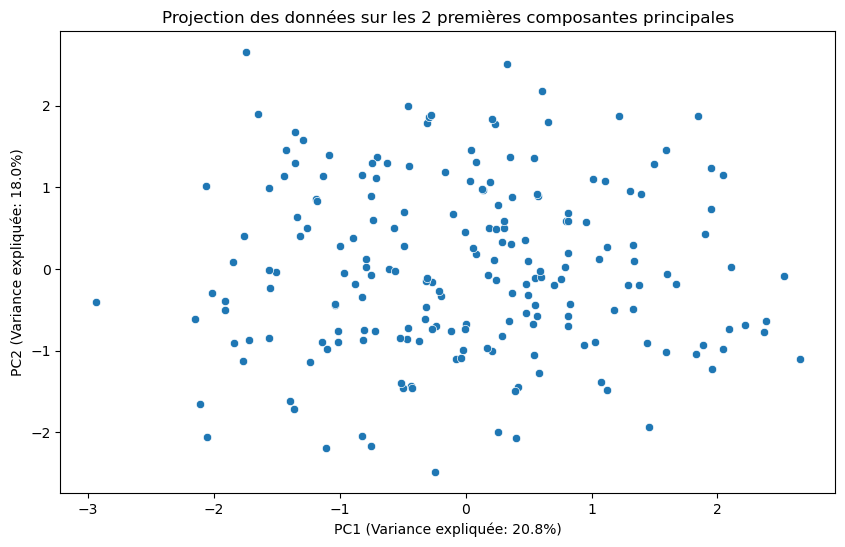

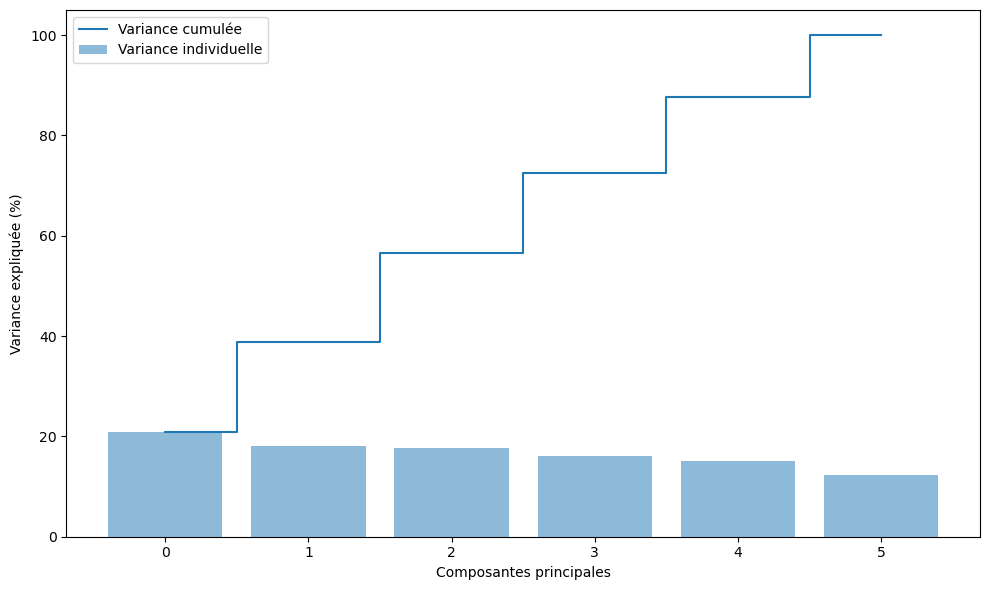

In [37]:

# Sélection et standardisation des variables
X = data.drop(['Taux_survie_%', 'Cout_elevage_FCFA', 'Age_group'], axis=1)
X_std = StandardScaler().fit_transform(X)

# Calcul de la matrice de covariance
cov_matrix = np.cov(X_std.T)

# Calcul des valeurs et vecteurs propres
eigen_values, eigen_vectors = np.linalg.eig(cov_matrix)

# Tri par ordre décroissant
sorted_index = np.argsort(eigen_values)[::-1]
sorted_eigenvalues = eigen_values[sorted_index]
sorted_eigenvectors = eigen_vectors[:,sorted_index]

print("Valeurs propres triées:", sorted_eigenvalues)
print("\nVecteurs propres correspondants:")
print(sorted_eigenvectors)

# Projection sur les 2 premières composantes
n_components = 2
eigenvector_subset = sorted_eigenvectors[:,:n_components]
X_reduced = X_std.dot(eigenvector_subset)

# Création d'un DataFrame pour les composantes
principal_df = pd.DataFrame(X_reduced, columns=['PC1', 'PC2'])

# Visualisation
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', data=principal_df)
plt.title('Projection des données sur les 2 premières composantes principales')
plt.xlabel(f'PC1 (Variance expliquée: {sorted_eigenvalues[0]/sum(sorted_eigenvalues)*100:.1f}%)')
plt.ylabel(f'PC2 (Variance expliquée: {sorted_eigenvalues[1]/sum(sorted_eigenvalues)*100:.1f}%)')
plt.show()

# Calcul du nombre optimal de composantes
total = sum(sorted_eigenvalues)
variance_explained = [(i / total)*100 for i in sorted_eigenvalues]
cumulative_variance_explained = np.cumsum(variance_explained)

plt.figure(figsize=(10, 6))
plt.bar(range(len(variance_explained)), variance_explained, alpha=0.5, align='center', label='Variance individuelle')
plt.step(range(len(cumulative_variance_explained)), cumulative_variance_explained, where='mid', label='Variance cumulée')
plt.ylabel('Variance expliquée (%)')
plt.xlabel('Composantes principales')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

Après analyse, on remaqure que 2 composantes représente 60% de la variance expliquée et 3 représentent 75%, on en conclut qu'on peut se limiter à 2 où 3 composantes après ACP

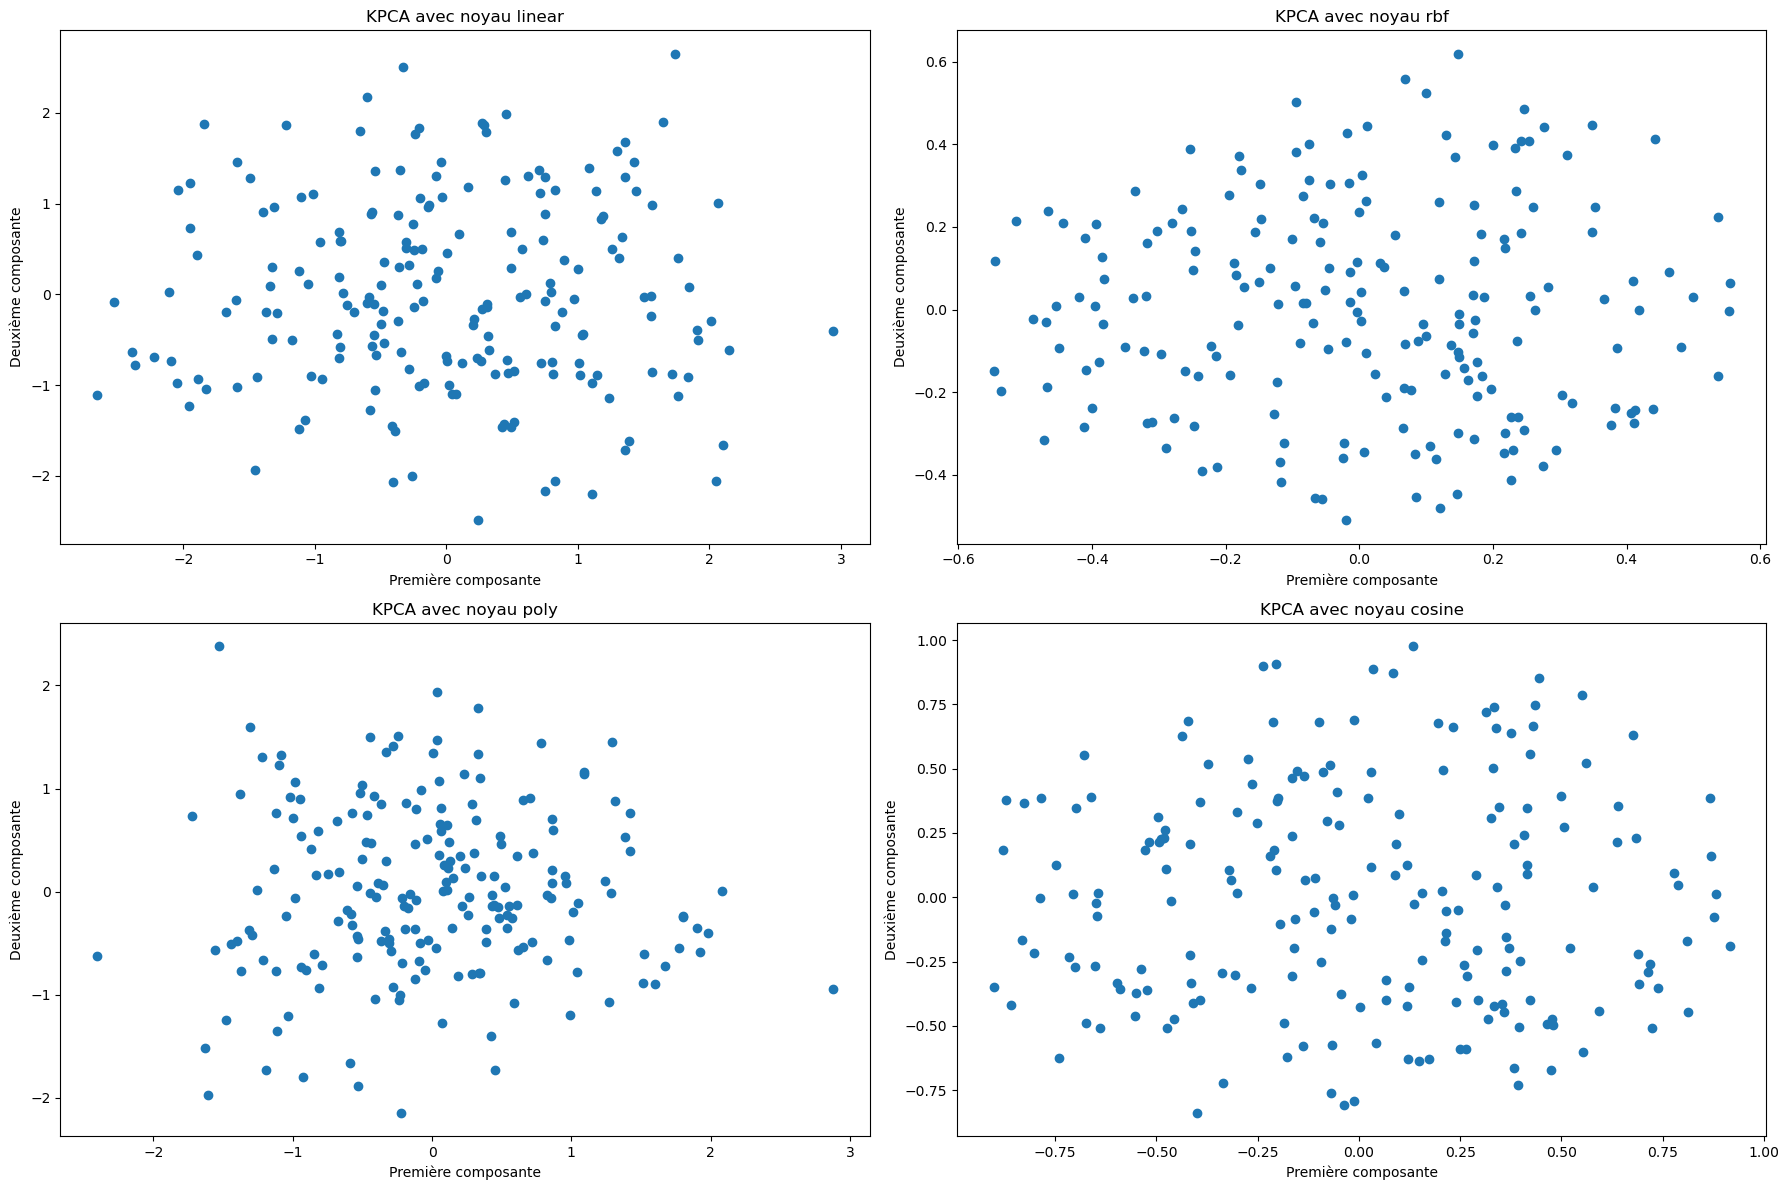

In [38]:

# Essai avec différents noyaux
kernels = ['linear', 'rbf', 'poly', 'cosine']
plt.figure(figsize=(18, 12))

for i, kernel in enumerate(kernels, 1):
    kpca = KernelPCA(n_components=2, kernel=kernel)
    X_kpca = kpca.fit_transform(X_std)
    
    plt.subplot(2, 2, i)
    plt.scatter(X_kpca[:, 0], X_kpca[:, 1])
    plt.title(f'KPCA avec noyau {kernel}')
    plt.xlabel('Première composante')
    plt.ylabel('Deuxième composante')

plt.tight_layout()
plt.show()

Que peut-on conclure de ces résultats ? 

L'Analyse en Composantes Principales (ACP) linéaire fournit des résultats comparables à ceux du KPCA lorsqu'on utilise un noyau linéaire

Mais, les noyaux RBF et polynomial permettent de faire ressortir des structures non linéaires qui resteraient invisibles avec l'ACP classique.

Le l'ACP à noyau est donc particulièrement intéressant lorsque les relations entre les variables sont complexes et non linéaires.

Avec nos données, l'ACP classique semble suffisante, car les données ne présentent pas de structures non linéaires marquées.


(----------------------------------------------)
## Excerice III
(----------------------------------------------)

Accuracy: 0.48333333333333334
F1-score: 0.4745762711864407


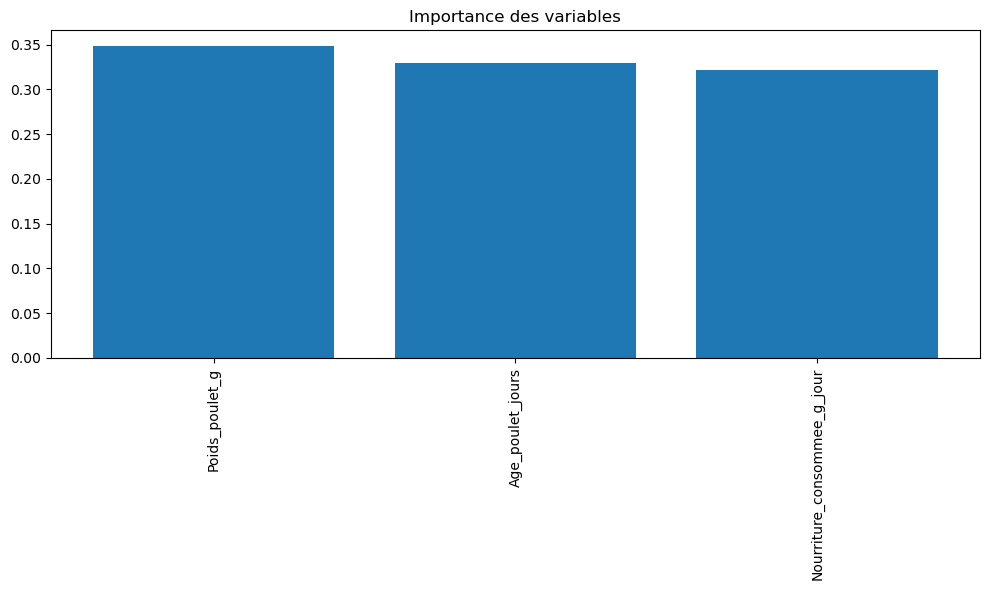

In [39]:

# Préparation des données
# 1. Classification binaire
y = (data['Taux_survie_%'] > 90).astype(int)  # Seuil à ajuster

# 2. Sélection de features
X = data[['Poids_poulet_g', 'Age_poulet_jours', 'Nourriture_consommee_g_jour']]

# 3. Modèle
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
rf = RandomForestClassifier(n_estimators=150, class_weight='balanced', max_depth=5)
rf.fit(X_train, y_train)

# 4. Évaluation
y_pred = rf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1-score:", f1_score(y_test, y_pred))
# Importance des variables
importances = rf.feature_importances_
features = X.columns
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,6))
plt.title("Importance des variables")
plt.bar(range(X.shape[1]), importances[indices], align='center')
plt.xticks(range(X.shape[1]), features[indices], rotation=90)
plt.tight_layout()
plt.show()

On déduit que le modèle sous cette forme est peu précis (de l'ordre de 55%), et prédis moyennement bien. Plusieurs paramètres pourraient modifier le résultats, ou bien même la présence ou non de plus ou moins de variable explicative.

On déduit l'ordre d'importance des variables sous cette forme : poids_poulet_g > Nourriture_consommee_g_jour > Age_poulet_jours ce qui confirme nos test anova/Student

In [40]:


# Préparation des données pour la régression
X = data.drop(['Gain_poids_jour_g', 'Age_group'], axis=1)
y = data['Gain_poids_jour_g']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# AdaBoost
ada = AdaBoostRegressor(n_estimators=100, random_state=42)
ada.fit(X_train, y_train)
ada_pred = ada.predict(X_test)
ada_mse = mean_squared_error(y_test, ada_pred)

# Gradient Boosting
gb = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb.fit(X_train, y_train)
gb_pred = gb.predict(X_test)
gb_mse = mean_squared_error(y_test, gb_pred)

print(f"AdaBoost MSE: {ada_mse:.3f}")
print(f"Gradient Boosting MSE: {gb_mse:.3f}")

AdaBoost MSE: 21.823
Gradient Boosting MSE: 26.971


On remarque que l'AdaBoost serait plus efficient, cependant, comme je n'ai pas trouver d'outliers, et qu'il est sensé en avoir, on peut remettre en cause ce résultat